# Szakdolgozat
## Tüdőbetegségek osztályozása kontrasztív tanulással

In [1]:
import os
import torch
import numpy as np
import random
class CFG:
    DATA_DIR     = "/kaggle/input/mimic-cxr-dataset"
    TRAIN_CSV    = "mimic_cxr_aug_train.csv"
    VAL_CSV      = "mimic_cxr_aug_validate.csv"
    IMAGE_ROOT   = "/kaggle/input/mimic-cxr-dataset/official_data_iccv_final"
    IMG_SIZE     = 224
    BATCH_SIZE   = 64
    EPOCHS       = 5
    LR           = 2e-4
    WEIGHT_DECAY = 1e-4
    SEED         = 42
    OUT_DIR      = "/kaggle/working/mimic_vit_out"
    MODEL_NAME   = "vit_base_patch16_224"
    FP16         = True
    TEXT_MODEL = "distilbert-base-uncased"
    MAX_LEN = 256
    DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

os.makedirs(CFG.OUT_DIR, exist_ok=True)

random.seed(CFG.SEED)
np.random.seed(CFG.SEED)
torch.manual_seed(CFG.SEED)

## A képek szűréséhez (mivel van úgy, hogy nincs meg a datasetben)

In [2]:
import pandas as pd
import ast
def parse_list_cell(x):
    """
    AP/PA/Lateral oszlopban lévő listák: 
    - lehet tényleges list
    - vagy string: "['files/....', 'files/...']"
    """
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    try:
        v = ast.literal_eval(str(x))
        if isinstance(v, list):
            return v
        return []
    except Exception:
        return []

def text_list_to_str(x):
    """
    text / text_augment oszlop:
    - lehet list: ['Findings: ...', 'Impression: ...']
    - vagy stringként eltárolt list
    - vagy sima string
    """
    if isinstance(x, list):
        return " ".join(map(str, x))
    try:
        v = ast.literal_eval(str(x))
        if isinstance(v, list):
            return " ".join(map(str, v))
    except Exception:
        pass
    if isinstance(x, str):
        return x
    return ""

def explode_views(df):
    """
    Eredeti sorok: egy beteg/study, több AP/PA/Lateral path listával.
    soronként 1 kép.
    """
    rows = []
    for _, r in df.iterrows():
        for p in parse_list_cell(r.get("AP", [])):
            nr = r.copy()
            nr["rel_path"] = p
            nr["view_used"] = "AP"
            rows.append(nr)
        for p in parse_list_cell(r.get("PA", [])):
            nr = r.copy()
            nr["rel_path"] = p
            nr["view_used"] = "PA"
            rows.append(nr)
        for p in parse_list_cell(r.get("Lateral", [])):
            nr = r.copy()
            nr["rel_path"] = p
            nr["view_used"] = "Lateral"
            rows.append(nr)
    out = pd.DataFrame(rows).reset_index(drop=True)
    return out

def exists_path(root, rel):
    """
    Egyszerű path ellenőrzés: root/rel létezik-e.
    """
    if not isinstance(rel, str):
        return False
    rel = rel.strip().lstrip("/").replace("\\", "/")
    p = os.path.join(root.rstrip("/"), rel)
    return os.path.exists(p)

## Train és validation adathalmazokra bontás

In [ ]:
from tqdm.auto import tqdm


# 1) CSV-k beolvasása
train_df = pd.read_csv(os.path.join(CFG.DATA_DIR, CFG.TRAIN_CSV))
val_df   = pd.read_csv(os.path.join(CFG.DATA_DIR, CFG.VAL_CSV))

print("Train shape (raw):", train_df.shape)
print("Val   shape (raw):", val_df.shape)

# 2) View-k felrobbantása (AP/PA/Lateral soronként 1 kép)
train_df = explode_views(train_df)
val_df   = explode_views(val_df)

print("Train shape (exploded):", train_df.shape)
print("Val   shape (exploded):", val_df.shape)

# 3) sima exists_path + tqdm, glob NÉLKÜL
def exists_path(root, rel):
    if not isinstance(rel, str):
        return False
    rel = rel.strip().lstrip("/").replace("\\", "/")
    p = os.path.join(root.rstrip("/"), rel)
    return os.path.exists(p)

before_tr, before_val = len(train_df), len(val_df)

print("Szűrés train_df képekre...")
mask_train = [
    exists_path(CFG.IMAGE_ROOT, rp)
    for rp in tqdm(train_df["rel_path"], total=len(train_df))
]
train_df = train_df[mask_train].reset_index(drop=True)

print("Szűrés val_df képekre...")
mask_val = [
    exists_path(CFG.IMAGE_ROOT, rp)
    for rp in tqdm(val_df["rel_path"], total=len(val_df))
]
val_df = val_df[mask_val].reset_index(drop=True)

print(f"Szűrés után: train {before_tr} → {len(train_df)}, val {before_val} → {len(val_df)}")

## Kimentjük a két szűrt adathalmazt

In [ ]:
OUT_DIR = "/kaggle/working/"
OUTPUT_TRAIN_CSV = os.path.join(OUT_DIR, "train_filtered.csv")
OUTPUT_VAL_CSV = os.path.join(OUT_DIR, "val_filtered.csv")

train_df.to_csv(OUTPUT_TRAIN_CSV, index=False)
val_df.to_csv(OUTPUT_VAL_CSV, index=False)

print(f"Train adatkeret kimentve ide: {OUTPUT_TRAIN_CSV}")
print(f"Validation adatkeret kimentve ide: {OUTPUT_VAL_CSV}")

In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

# röntgenre ésszerű augmentációk
def get_contrastive_transform(img_size=CFG.IMG_SIZE):
    return T.Compose([
        T.Resize(int(img_size * 1.1)),
        T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        T.RandomRotation(10),
        T.RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        # 1 csatornából csinálunk 3-at ViT-hez
        T.Lambda(lambda x: x.repeat(3, 1, 1)),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]),
    ])

class MimicSimCLRDataset(Dataset):
    def __init__(self, df, img_root, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_root = CFG.IMAGE_ROOT  # vagy img_root paraméter
        self.transform = transform or get_contrastive_transform(CFG.IMG_SIZE)

    def __len__(self):
        return len(self.df)

    def _load_image(self, rel_path: str):
        rel_path = rel_path.strip().lstrip("/").replace("\\", "/")
        full_path = os.path.join(self.img_root.rstrip("/"), rel_path)
        img = Image.open(full_path).convert("L")  # mellkasröntgen -> grayscale
        return img

    def __getitem__(self, idx):
        rel_path = self.df.loc[idx, "rel_path"]
        img = self._load_image(rel_path)

        # SimCLR: két külön augmentáció ugyanarra a képre
        x1 = self.transform(img)
        x2 = self.transform(img)
        return x1, x2

contrastive_transform = get_contrastive_transform(CFG.IMG_SIZE)

train_contrastive_ds = MimicSimCLRDataset(train_df, CFG.IMAGE_ROOT, transform=contrastive_transform)
val_contrastive_ds   = MimicSimCLRDataset(val_df,   CFG.IMAGE_ROOT, transform=contrastive_transform)

train_loader = DataLoader(
    train_contrastive_ds,
    batch_size=CFG.BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

val_loader = DataLoader(
    val_contrastive_ds,
    batch_size=CFG.BATCH_SIZE,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

print("Train contrastive samples:", len(train_contrastive_ds))
print("Val   contrastive samples:", len(val_contrastive_ds))


## Modell létrehozása

In [3]:
import torch.nn as nn
import torchvision.models as models

class ResNet50_SimCLR(nn.Module):
    def __init__(self, proj_dim=128):
        super().__init__()

        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        feat_dim = backbone.fc.in_features
        backbone.fc = nn.Identity()  # eltávolítjuk a klasszifikációs fejet

        self.encoder = backbone

        self.projector = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.ReLU(inplace=True),
            nn.Linear(feat_dim, proj_dim)
        )

    def forward(self, x):
        h = self.encoder(x)      # [B, 2048]
        z = self.projector(h)    # [B, 128]
        return h, z

model = ResNet50_SimCLR().to(CFG.DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s] 


## Loss függvény

In [ ]:
import torch.nn.functional as F

def nt_xent_loss(z1, z2, temperature=0.5):
    B = z1.size(0)

    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    z = torch.cat([z1, z2], dim=0)   # 2B x D
    sim = torch.matmul(z, z.T) / temperature

    mask = torch.eye(2*B, dtype=torch.bool, device=z.device)
    neg_inf = -torch.finfo(sim.dtype).max
    sim = sim.masked_fill(mask, neg_inf)

    pos_idx = (torch.arange(2*B, device=z.device) + B) % (2*B)

    loss = F.cross_entropy(sim, pos_idx)
    return loss


## SimCLR encoder betanítása (ez kell majd a VLM-hez)

In [ ]:
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=CFG.LR, 
    weight_decay=CFG.WEIGHT_DECAY
)

scaler = torch.amp.GradScaler('cuda', enabled=CFG.FP16)

for epoch in range(CFG.EPOCHS):
    model.train()
    running_loss = 0.0

    pbar = tqdm(
        train_loader, 
        total=len(train_loader),
        desc=f"Epoch {epoch+1}/{CFG.EPOCHS}",
        leave=False
    )

    for step, (x1, x2) in enumerate(pbar):
        x1 = x1.to(DEVICE, non_blocking=True)
        x2 = x2.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast('cuda', enabled=CFG.FP16):
            _, z1 = model(x1)
            _, z2 = model(x2)
            loss = nt_xent_loss(z1, z2)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        avg_loss = running_loss / (step + 1)

        # tqdm bar-ra kiírás
        pbar.set_postfix({"loss": f"{avg_loss:.4f}"})

    print(f">>> Epoch {epoch+1} avg loss: {running_loss/len(train_loader):.4f}")

torch.save(model.encoder.state_dict(), f"{CFG.OUT_DIR}/resnet50_simclr_encoder.pth")
print("Mentve: resnet50_simclr_encoder.pth")


In [6]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import pandas as pd
from tqdm import tqdm

val_df = pd.read_csv("/kaggle/input/validation-dataset/val_filtered.csv")

def get_eval_transform(img_size=224):
    return T.Compose([
        T.Resize(img_size),
        T.CenterCrop(img_size),
        T.ToTensor(),
        T.Lambda(lambda x: x.repeat(3, 1, 1)),
        T.Normalize(mean=[0.5,0.5,0.5], std=[0.25,0.25,0.25]),
    ])

class MimicSingleViewDataset(Dataset):
    def __init__(self, df, img_root, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_root = img_root
        self.transform = transform or get_eval_transform(CFG.IMG_SIZE)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rel = self.df.loc[idx, "rel_path"].strip().lstrip("/").replace("\\", "/")
        p = os.path.join(self.img_root.rstrip("/"), rel)
        img = Image.open(p).convert("L")
        x = self.transform(img)
        return x

eval_ds = MimicSingleViewDataset(val_df, CFG.IMAGE_ROOT)
eval_loader = DataLoader(eval_ds, batch_size=128, shuffle=False, num_workers=1)

model.encoder.load_state_dict(torch.load("/kaggle/input/resnet50-simclr-encoder/pytorch/default/1/resnet50_simclr_encoder.pth", map_location=CFG.DEVICE))
model.eval()

embs = []
with torch.no_grad():
    for x in tqdm(eval_loader, desc="Embedding kinyerés"):
        x = x.to(CFG.DEVICE)
        h, _ = model(x)
        embs.append(h.cpu().numpy())

embs = np.concatenate(embs, axis=0)
print("Embeddings:", embs.shape)


Embedding kinyerés: 100%|██████████| 15/15 [00:39<00:00,  2.63s/it]

Embeddings: (1854, 2048)


## Klaszterezés

In [7]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# gyorsítás: PCA 2048 -> 64
X = PCA(n_components=64, random_state=CFG.SEED).fit_transform(embs)

Ks = [2,3,4,5,6,8,10,12,15,20]
results = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=CFG.SEED, n_init="auto")
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    results.append((k, sil, dbi))
    print(f"K={k:2d} | silhouette={sil:.4f} | DBI={dbi:.4f}")


K= 2 | silhouette=0.0570 | DBI=4.1697
K= 3 | silhouette=0.0686 | DBI=3.2826
K= 4 | silhouette=0.0783 | DBI=3.2077
K= 5 | silhouette=0.0676 | DBI=3.1006
K= 6 | silhouette=0.0678 | DBI=2.8209
K= 8 | silhouette=0.1012 | DBI=2.4551
K=10 | silhouette=0.1172 | DBI=2.1733
K=12 | silhouette=0.1289 | DBI=2.1491
K=15 | silhouette=0.1476 | DBI=1.9249
K=20 | silhouette=0.1497 | DBI=1.8621


In [8]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

# 1) PCA
X = PCA(n_components=64, random_state=CFG.SEED).fit_transform(embs)

# 2) KMeans (válassz K-t)
K = 20   # vagy 20
km = KMeans(n_clusters=K, random_state=CFG.SEED, n_init="auto")
labels = km.fit_predict(X)

# 3) gyors stat
unique, counts = np.unique(labels, return_counts=True)
print("Cluster sizes:")
for c, n in sorted(zip(unique, counts), key=lambda t: t[1], reverse=True):
    print(f"  cluster {c:2d}: {n}")


Cluster sizes:
  cluster  1: 209
  cluster  3: 192
  cluster 12: 136
  cluster  6: 111
  cluster 16: 109
  cluster 13: 105
  cluster 15: 105
  cluster  0: 101
  cluster  2: 98
  cluster  4: 98
  cluster 10: 95
  cluster 18: 93
  cluster 14: 87
  cluster  9: 71
  cluster 11: 66
  cluster  5: 56
  cluster 17: 41
  cluster 19: 38
  cluster  7: 34
  cluster  8: 9


In [13]:
val_df_km = val_df.reset_index(drop=True).copy()
val_df_km["kmeans_cluster"] = labels


val_df_km

Unnamed: 0.1  Unnamed: 0  subject_id  \
0                0          30    10003502   
1                0          30    10003502   
2                0          30    10003502   
3                0          30    10003502   
4                0          30    10003502   
...            ...         ...         ...   
1849           499       65074    19950864   
1850           499       65074    19950864   
1851           499       65074    19950864   
1852           499       65074    19950864   
1853           499       65074    19950864   

                                                  image  \
0     ['files/p10/p10003502/s50084553/70d7e600-373c1...   
1     ['files/p10/p10003502/s50084553/70d7e600-373c1...   
2     ['files/p10/p10003502/s50084553/70d7e600-373c1...   
3     ['files/p10/p10003502/s50084553/70d7e600-373c1...   
4     ['files/p10/p10003502/s50084553/70d7e600-373c1...   
...                                                 ...   
1849  ['files/p19/p19950864/s50986956/6895d4bc-d096e...   
1850  ['files/p19/p19950864/s50986956/6895d4bc-d096e...   
1851  ['files/p19/p19950864/s50986956/6895d4bc-d096e...   
1852  ['files/p19/p19950864/s50986956/6895d4bc-d096e...   
1853  ['files/p19/p19950864/s50986956/6895d4bc-d096e...   

                               view  \
0     ['AP', 'LATERAL', 'LL', 'PA']   
1     ['AP', 'LATERAL', 'LL', 'PA']   
2     ['AP', 'LATERAL', 'LL', 'PA']   
3     ['AP', 'LATERAL', 'LL', 'PA']   
4     ['AP', 'LATERAL', 'LL', 'PA']   
...                             ...   
1849        ['PA', 'LATERAL', 'AP']   
1850        ['PA', 'LATERAL', 'AP']   
1851        ['PA', 'LATERAL', 'AP']   
1852        ['PA', 'LATERAL', 'AP']   
1853        ['PA', 'LATERAL', 'AP']   

                                                     AP  \
0     ['files/p10/p10003502/s50084553/70d7e600-373c1...   
1     ['files/p10/p10003502/s50084553/70d7e600-373c1...   
2     ['files/p10/p10003502/s50084553/70d7e600-373c1...   
3     ['files/p10/p10003502/s50084553/70d7e600-373c1...   
4     ['files/p10/p10003502/s50084553/70d7e600-373c1...   
...                                                 ...   
1849  ['files/p19/p19950864/s53502057/1fc7bf88-79d4d...   
1850  ['files/p19/p19950864/s53502057/1fc7bf88-79d4d...   
1851  ['files/p19/p19950864/s53502057/1fc7bf88-79d4d...   
1852  ['files/p19/p19950864/s53502057/1fc7bf88-79d4d...   
1853  ['files/p19/p19950864/s53502057/1fc7bf88-79d4d...   

                                                     PA  \
0     ['files/p10/p10003502/s57812613/1efa55e3-0a385...   
1     ['files/p10/p10003502/s57812613/1efa55e3-0a385...   
2     ['files/p10/p10003502/s57812613/1efa55e3-0a385...   
3     ['files/p10/p10003502/s57812613/1efa55e3-0a385...   
4     ['files/p10/p10003502/s57812613/1efa55e3-0a385...   
...                                                 ...   
1849  ['files/p19/p19950864/s50986956/6895d4bc-d096e...   
1850  ['files/p19/p19950864/s50986956/6895d4bc-d096e...   
1851  ['files/p19/p19950864/s50986956/6895d4bc-d096e...   
1852  ['files/p19/p19950864/s50986956/6895d4bc-d096e...   
1853  ['files/p19/p19950864/s50986956/6895d4bc-d096e...   

                                                Lateral  \
0     ['files/p10/p10003502/s51180958/a8319f39-9eef5...   
1     ['files/p10/p10003502/s51180958/a8319f39-9eef5...   
2     ['files/p10/p10003502/s51180958/a8319f39-9eef5...   
3     ['files/p10/p10003502/s51180958/a8319f39-9eef5...   
4     ['files/p10/p10003502/s51180958/a8319f39-9eef5...   
...                                                 ...   
1849  ['files/p19/p19950864/s50986956/a8db31e4-f0fa9...   
1850  ['files/p19/p19950864/s50986956/a8db31e4-f0fa9...   
1851  ['files/p19/p19950864/s50986956/a8db31e4-f0fa9...   
1852  ['files/p19/p19950864/s50986956/a8db31e4-f0fa9...   
1853  ['files/p19/p19950864/s50986956/a8db31e4-f0fa9...   

                                                   text  \
0     ['Findings:  Impression: Compared to chest rad...   
1     ['Findings:  Impression:

## Grad-CAM vizualizáció

In [7]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self._forward_hook)
        self.target_layer.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, x):
        self.model.zero_grad()
    
        out = self.model(x)
        h = out[0] if isinstance(out, tuple) else out
    
        score = h.mean()
        score.backward()
    
        grads = self.gradients
        acts  = self.activations
    
        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = (weights * acts).sum(dim=1)
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam.cpu().numpy()



def sample_cluster(df, cluster_id, n=5):
    return df[df["kmeans_cluster"] == cluster_id].sample(
        n=min(n, (df["kmeans_cluster"] == cluster_id).sum()),
        random_state=CFG.SEED
    )


In [13]:
import re
NEGATIONS = [
    "no", "without", "absence of", "absent", "negative for", "free of",
    "neither", "nor"
]

UNCERTAIN = [
    "cannot exclude", "can't exclude", "difficult to exclude",
    "possible", "possibly", "may represent", "might represent",
    "could represent", "suggestive of", "suspicious for", "probable",
    "likely", "question of", "consider", "cannot rule out", "can't rule out"
]

# Betegség -> kulcsszó/regex minták (bővíthető)
DISEASE_PATTERNS = {
    "pleural_effusion": [
        r"\bpleural effusion(s)?\b",
        r"\beffusion(s)?\b",
        r"\bblunting of the costophrenic angle(s)?\b"
    ],
    "pneumothorax": [
        r"\bpneumothorax\b",
        r"\bptx\b"
    ],
    "pneumonia": [
        r"\bpneumonia\b",
        r"\baspiration pneumonia\b"
    ],
    "atelectasis": [
        r"\batelectasis\b",
        r"\bsubsegmental atelectasis\b",
        r"\bbibasilar atelectasis\b"
    ],
    "cardiomegaly": [
        r"\bcardiomegaly\b",
        r"\benlarged heart\b",
        r"\bheart size is (mildly |moderately |severely )?enlarged\b"
    ],
    "pulmonary_edema": [
        r"\bpulmonary edema\b",
        r"\binterstitial edema\b",
        r"\bvascular congestion\b",
        r"\bcongestive heart failure\b",
        r"\bCHF\b"
    ],
    "consolidation": [
        r"\bconsolidation\b",
        r"\bairspace consolidation\b"
    ],
    "lung_opacity": [
        r"\bopacity\b",
        r"\bopacities\b",
        r"\bairspace disease\b",
        r"\binfiltrate(s)?\b",
        r"\binfiltration\b"
    ],
    "support_devices": [
        r"\bendotracheal tube\b",
        r"\btracheostomy\b",
        r"\bcentral venous catheter\b",
        r"\bpicc\b",
        r"\bpacemaker\b",
        r"\bchest tube\b"
    ],
    "normal_no_finding": [
        r"\bno acute cardiopulmonary (process|abnormality|disease)\b",
        r"\bno acute disease\b",
        r"\bno acute abnormality\b",
        r"\bwithin normal limits\b",
        r"\bnormal chest\b",
        r"\bnormal study\b",
        r"\bno active disease\b",
        r"\bno significant abnormality\b",
        r"\blungs are clear\b",
        r"\bheart size is normal\b",
        r"\bnormal cardiac silhouette\b"
    ]
}

def _token_index(text, char_pos):
    return len(text[:char_pos].split())

def _has_negation_near(text, char_start, window_tokens=8):
    words = text.split()
    idx = _token_index(text, char_start)
    start = max(0, idx - window_tokens)
    end = min(len(words), idx + window_tokens)
    context = " ".join(words[start:end]).lower()
    return any(n in context for n in NEGATIONS)

def _has_uncertainty_near(text, char_start, char_end, window_chars=60):
    t = text.lower()
    s = max(0, char_start - window_chars)
    e = min(len(t), char_end + window_chars)
    context = t[s:e]
    return any(u in context for u in UNCERTAIN)

def classify_condition(text, patterns):
    """
    Visszatér:
      - "positive" / "negative" / "uncertain" / "not_mentioned" / "unknown"
    Baseline logika: ha talált mintát, megnézi van-e negáció / bizonytalanság a közelben.
    """
    if not isinstance(text, str):
        return "unknown"

    t = text.lower()
    for pat in patterns:
        for m in re.finditer(pat, t):
            if _has_negation_near(t, m.start()):
                return "negative"
            if _has_uncertainty_near(t, m.start(), m.end()):
                return "uncertain"
            return "positive"

    return "not_mentioned"


In [25]:
def cluster_condition_table(df, cluster_col="kmeans_cluster", text_col="text",
                            min_relevant=20):
    """
    Kimenet:
      - ratio_df: cluster x disease mátrix (pozitív arány a 'relevant' esetek között)
      - counts_df: részletes counts (pos/neg/unc/not_mentioned/relevant)
    """
    work = df[[cluster_col, text_col]].copy()

    # per-row label minden betegségre
    for disease, pats in DISEASE_PATTERNS.items():
        work[disease] = work[text_col].apply(lambda x: classify_condition(x, pats))

    # cluster x disease aggregáció
    ratio_rows = []
    count_rows = []

    for c, g in work.groupby(cluster_col):
        row_ratio = {"cluster": int(c)}
        row_count = {"cluster": int(c), "total": int(len(g))}

        for disease in DISEASE_PATTERNS.keys():
            pos = int((g[disease] == "positive").sum())
            neg = int((g[disease] == "negative").sum())
            unc = int((g[disease] == "uncertain").sum())
            nm  = int((g[disease] == "not_mentioned").sum())

            relevant = pos + neg + unc
            ratio = (pos / relevant) if relevant > 0 else 0.0

            # ratio mátrixba csak a ratio megy
            row_ratio[disease] = ratio

            # counts táblába minden megy (disease prefixszel)
            row_count[f"{disease}_pos"] = pos
            row_count[f"{disease}_neg"] = neg
            row_count[f"{disease}_unc"] = unc
            row_count[f"{disease}_nm"]  = nm
            row_count[f"{disease}_rel"] = relevant

        ratio_rows.append(row_ratio)
        count_rows.append(row_count)

    ratio_df = pd.DataFrame(ratio_rows).set_index("cluster").sort_index()
    counts_df = pd.DataFrame(count_rows).set_index("cluster").sort_index()

    # opcionális: min_relevant szűrés csak a dominancia listáknál (lent használjuk)
    return ratio_df, counts_df


ratio_df, counts_df = cluster_condition_table(val_df_km, cluster_col="kmeans_cluster", text_col="text")

display(ratio_df.head())
display(counts_df.head())



pleural_effusion  pneumothorax  pneumonia  atelectasis  cardiomegaly  \
cluster                                                                         
0                0.122449      0.030928   0.183333     0.169492      0.771429   
1                0.199005      0.066327   0.194915     0.350000      0.344262   
2                0.142857      0.000000   0.067416     0.465116      0.477612   
3                0.063830      0.000000   0.126866     0.368421      0.298077   
4                0.311111      0.000000   0.250000     0.443182      0.461538   

         pulmonary_edema  consolidation  lung_opacity  support_devices  \
cluster                                                                  
0               0.243243       0.306667      0.455882         0.711538   
1               0.166667       0.222222      0.266667         0.552632   
2               0.419355       0.369565      0.382022         0.568182   
3               0.170068       0.167742      0.239130         0.547368   
4               0.402299       0.346667      0.309524         0.621212   

         normal_no_finding  
cluster                     
0                 0.012987  
1                 0.012821  
2                 0.000000  
3                 0.033557  
4                 0.017544

total  pleural_effusion_pos  pleural_effusion_neg  \
cluster                                                      
0          101                    12                    86   
1          209                    40                   160   
2           98                    14                    81   
3          192                    12                   165   
4           98                    28                    58   

         pleural_effusion_unc  pleural_effusion_nm  pleural_effusion_rel  \
cluster                                                                    
0                           0                    3                    98   
1                           1                    8                   201   
2                           3                    0                    98   
3                          11                    4                   188   
4                           4                    8                    90   

         pneumothorax_pos  pneumothorax_neg  pneumothorax_unc  \
cluster                                                         
0                       3                94                 0   
1                      13               183                 0   
2                       0                96                 0   
3                       0               176                 0   
4                       0                89                 0   

         pneumothorax_nm  ...  support_devices_pos  support_devices_neg  \
cluster                   ...                                             
0                      4  ...                   37                   15   
1                     13  ...                   42                   34   
2                      2  ...                   50                   38   
3                     16  ...                   52                   43   
4                      9  ...                   41                   25   

         support_devices_unc  support_devices_nm  support_devices_rel  \
cluster                                                                 
0                          0                  49                   52   
1                          0                 133                   76   
2                          0                  10                   88   
3                          0                  97                   95   
4                          0                  32                   66   

         normal_no_finding_pos  normal_no_finding_neg  normal_no_finding_unc  \
cluster                                                                        
0                            1                     76                      0   
1                            2                    154                      0   
2                            0                     55                      0   
3                            5                    144                      0   
4                            1                     56                      0   

         normal_no_finding_nm  normal_no_finding_rel  
cluster                                               
0                          24                     77  
1                          53                    156  
2                          43                     55  
3                          43                    149  
4                          41                     57  

[5 rows x 51 columns]

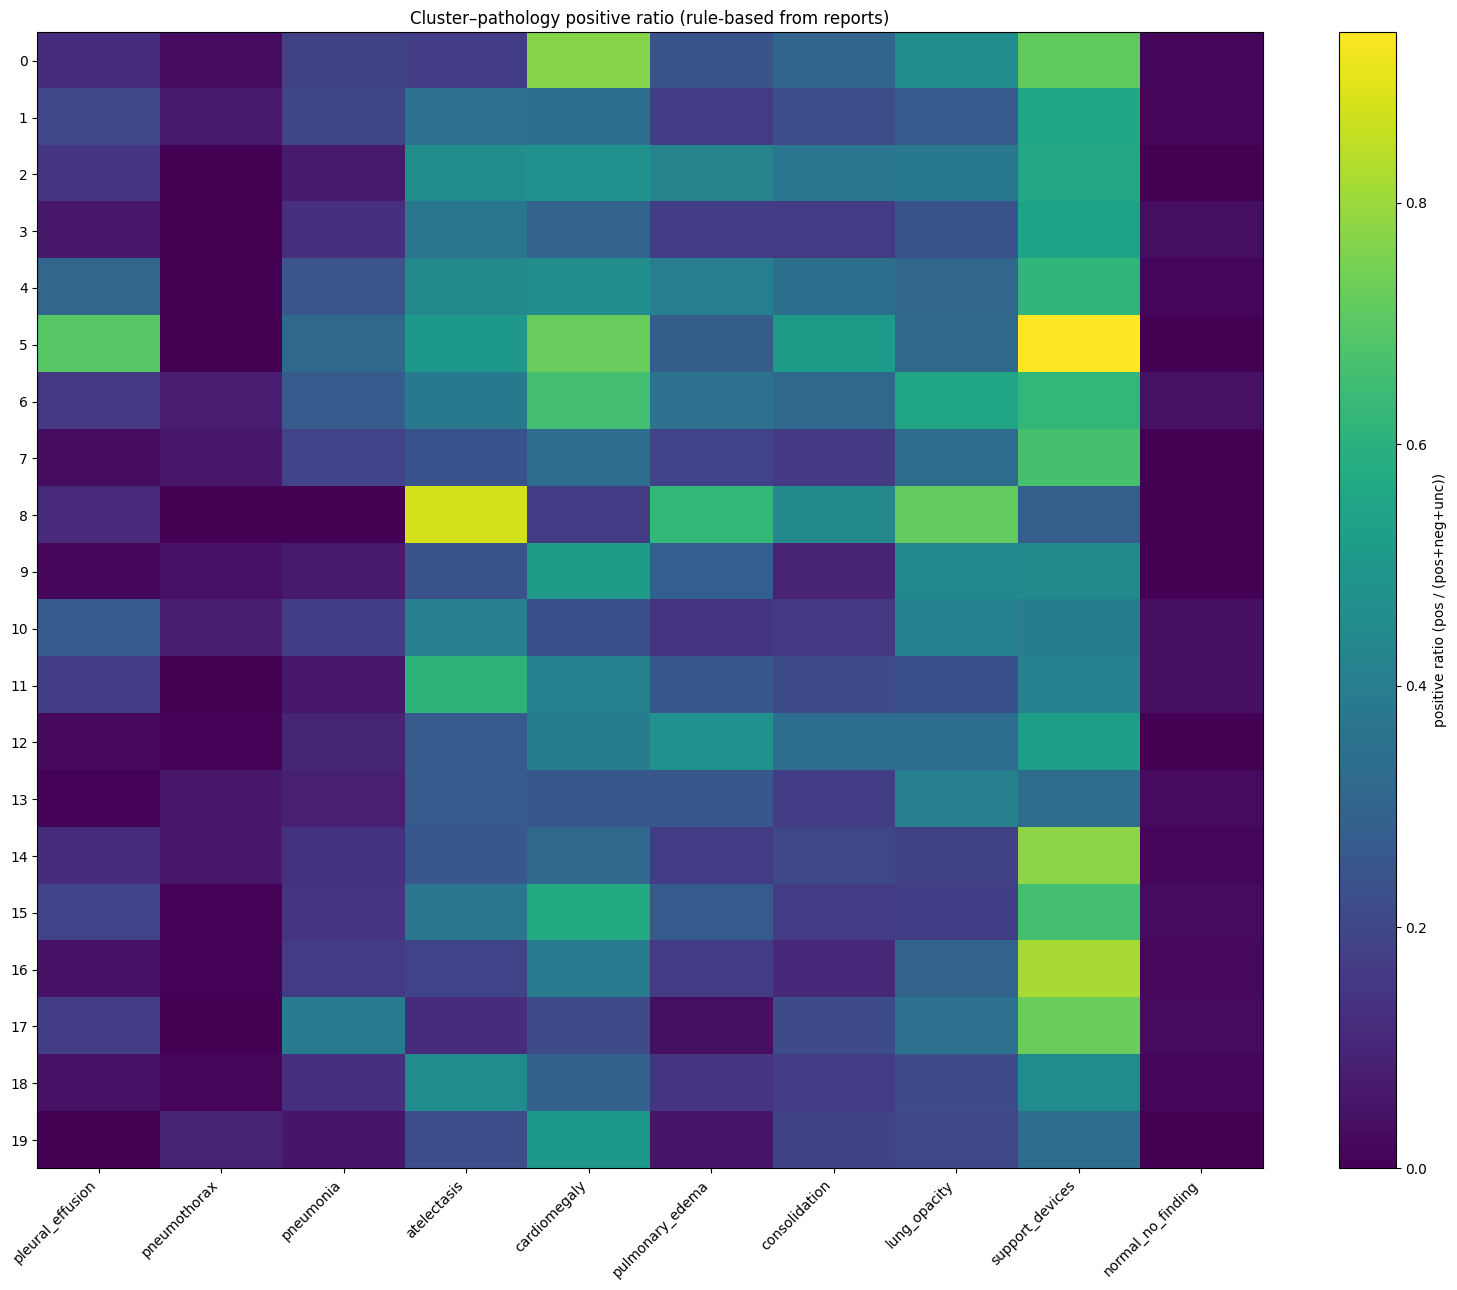

In [26]:
import matplotlib.pyplot as plt
def plot_heatmap(mat: pd.DataFrame, title="Cluster–pathology positive ratio heatmap"):
    data = mat.values
    plt.figure(figsize=(1.2*mat.shape[1] + 4, 0.45*mat.shape[0] + 4))
    plt.imshow(data, aspect="auto")
    plt.colorbar(label="positive ratio (pos / (pos+neg+unc))")
    plt.xticks(range(mat.shape[1]), mat.columns, rotation=45, ha="right")
    plt.yticks(range(mat.shape[0]), mat.index)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(ratio_df, title="Cluster–pathology positive ratio (rule-based from reports)")

In [32]:
# mely címkéket nézzük (hagyd ki, ami túl tág, ha zavar: lung_opacity)
labels = [
    "pleural_effusion", "atelectasis", "pneumonia", "cardiomegaly",
    "pulmonary_edema", "pneumothorax", "support_devices", "normal_no_finding"
]

def multilabel_profile_per_cluster(ratio_df, counts_df, labels, thr=0.3, min_rel=20, topk=4):
    rows = []
    for c in ratio_df.index:
        items = []
        for lab in labels:
            rel = counts_df.loc[c, f"{lab}_rel"]
            if rel < min_rel:
                continue
            ratio = float(ratio_df.loc[c, lab])
            if ratio >= thr:
                items.append((lab, ratio, int(rel)))
        # legnagyobb arány szerint
        items = sorted(items, key=lambda x: x[1], reverse=True)[:topk]
        rows.append({
            "cluster": c,
            "total": int(counts_df.loc[c, "total"]),
            "labels": ", ".join([f"{lab}({ratio:.2f}, rel={rel})" for lab, ratio, rel in items]) if items else "-"
        })
    return pd.DataFrame(rows).sort_values("cluster")

profile_df = multilabel_profile_per_cluster(
    ratio_df, counts_df, labels,
    thr=0.30,     # multi-label küszöb (lazább, mint 0.6)
    min_rel=20,   # legyen elég említés
    topk=4
)

profile_df


cluster  total                                             labels
0         0    101  cardiomegaly(0.77, rel=35), support_devices(0....
1         1    209  support_devices(0.55, rel=76), atelectasis(0.3...
2         2     98  support_devices(0.57, rel=88), cardiomegaly(0....
3         3    192  support_devices(0.55, rel=95), atelectasis(0.3...
4         4     98  support_devices(0.62, rel=66), cardiomegaly(0....
5         5     56  support_devices(0.94, rel=51), cardiomegaly(0....
6         6    111  cardiomegaly(0.66, rel=59), support_devices(0....
7         7     34                                                  -
8         8      9                                                  -
9         9     71  cardiomegaly(0.52, rel=29), support_devices(0....
10       10     95  atelectasis(0.41, rel=66), support_devices(0.4...
11       11     66  atelectasis(0.61, rel=54), cardiomegaly(0.41, ...
12       12    136  support_devices(0.53, rel=91), pulmonary_edema...
13       13    105                      support_devices(0.33, rel=39)
14       14     87  support_devices(0.78, rel=27), cardiomegaly(0....
15       15    105  support_devices(0.66, rel=59), cardiomegaly(0....
16       16    109  support_devices(0.82, rel=33), cardiomegaly(0....
17       17     41                            pneumonia(0.39, rel=23)
18       18     93  atelectasis(0.46, rel=48), support_devices(0.4...
19       19     38                                                  -

In [39]:
import cv2
import numpy as np
from PIL import Image
import torch

cam = GradCAM(model, model.encoder.layer4[-1])
def compute_gradcam_overlay(img_path, cam, device, size=224):
    img = Image.open(img_path).convert("L")
    img = img.resize((size, size))
    img_np = np.array(img)

    x = torch.tensor(img_np, dtype=torch.float32) / 255.0
    x = x.unsqueeze(0).unsqueeze(0)
    x = x.repeat(1,3,1,1).to(device)

    cam_map = cam(x)[0]
    cam_map = cv2.resize(cam_map, (size, size))
    cam_map = 1.0 - cam_map

    heatmap = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
    overlay = 0.6 * heatmap + 0.4 * cv2.cvtColor(img_np, cv2.COLOR_GRAY2BGR)

    return overlay.astype(np.uint8)


In [43]:
def cluster_label_string(cluster_id, ratio_df, counts_df,
                          labels,
                          thr=0.30, min_rel=20, topk=3):
    items = []
    for lab in labels:
        rel = counts_df.loc[cluster_id, f"{lab}_rel"]
        if rel < min_rel:
            continue
        ratio = float(ratio_df.loc[cluster_id, lab])
        if ratio >= thr:
            items.append((lab, ratio, rel))

    items = sorted(items, key=lambda x: x[1], reverse=True)[:topk]

    if not items:
        return "no dominant pathology"

    return " | ".join([f"{lab} ({ratio:.2f})" for lab, ratio, _ in items])

def plot_all_cluster_gradcams_with_labels(
    df, cam, image_root, device,
    ratio_df, counts_df, labels,
    samples_per_cluster=3, size=224,
    max_clusters=None, seed=42
):
    clusters = sorted(df["kmeans_cluster"].unique())
    if max_clusters is not None:
        clusters = clusters[:max_clusters]

    for c in clusters:
        subset = df[df["kmeans_cluster"] == c]
        if len(subset) == 0:
            continue

        sample = subset.sample(n=min(samples_per_cluster, len(subset)),
                               random_state=seed)

        # 🔹 klaszter betegségprofil
        label_str = cluster_label_string(
            c, ratio_df, counts_df, labels,
            thr=0.30, min_rel=20, topk=3
        )

        plt.figure(figsize=(4 * samples_per_cluster, 4))
        for i, (_, row) in enumerate(sample.iterrows()):
            rel = row["rel_path"].strip().lstrip("/").replace("\\", "/")
            img_path = os.path.join(image_root.rstrip("/"), rel)

            overlay = compute_gradcam_overlay(img_path, cam, device, size=size)

            ax = plt.subplot(1, samples_per_cluster, i + 1)
            ax.imshow(overlay)
            ax.axis("off")
            ax.set_title(f"Cluster {c}", fontsize=10)

        plt.suptitle(
            f"Cluster {c} (n={len(subset)})\n{label_str}",
            fontsize=13
        )
        plt.tight_layout()
        plt.show()


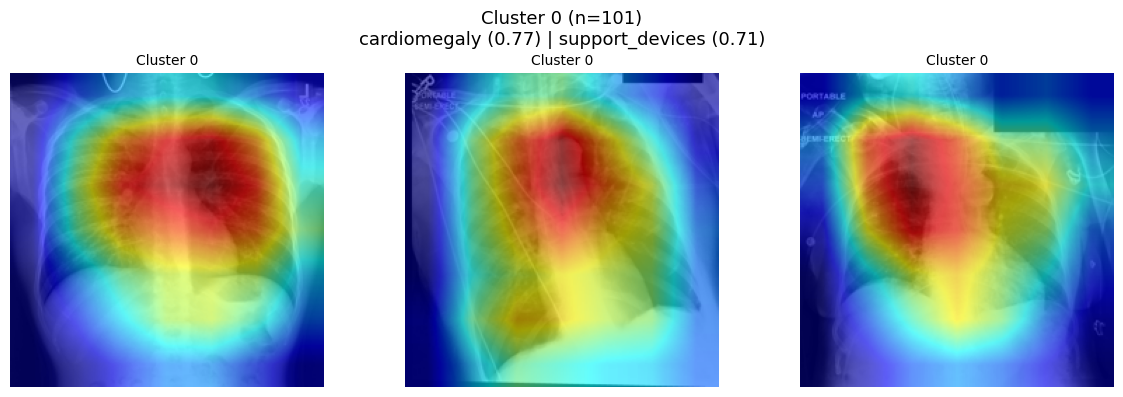

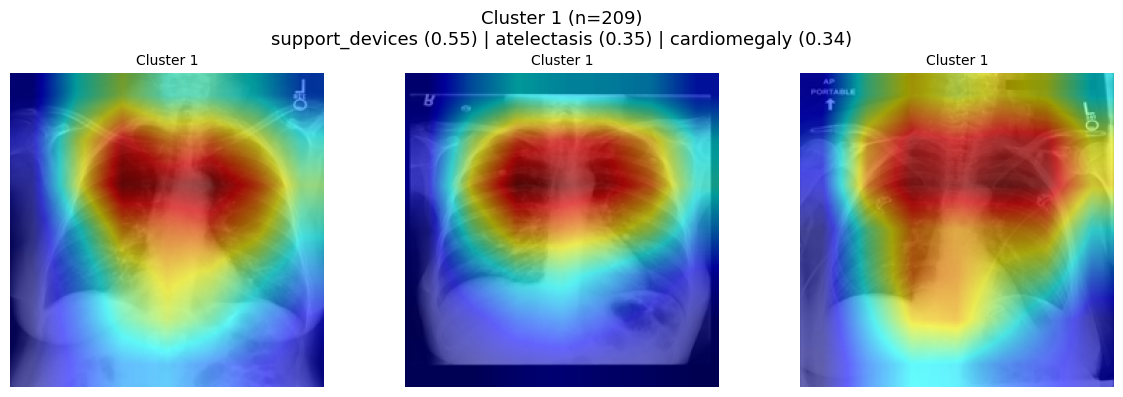

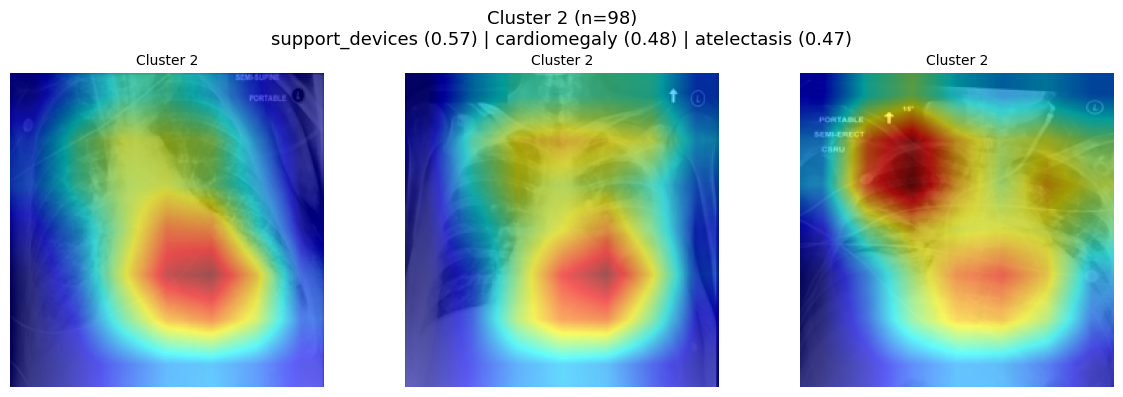

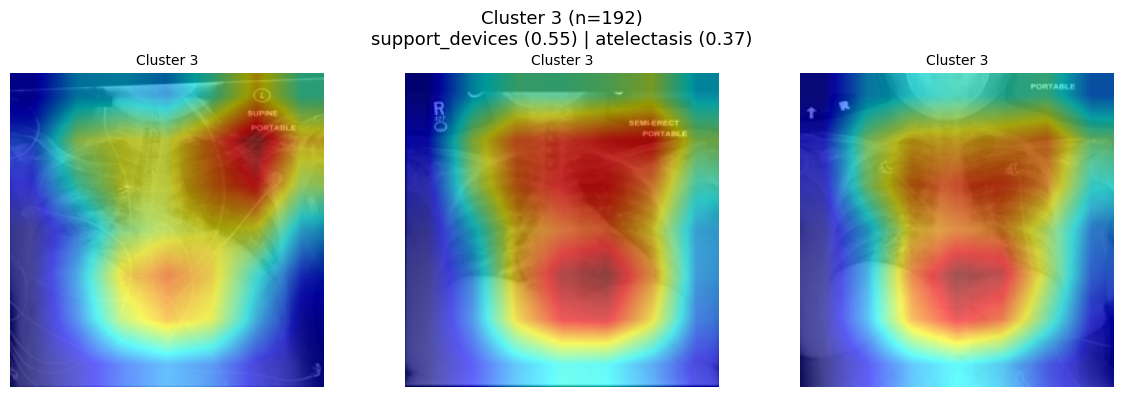

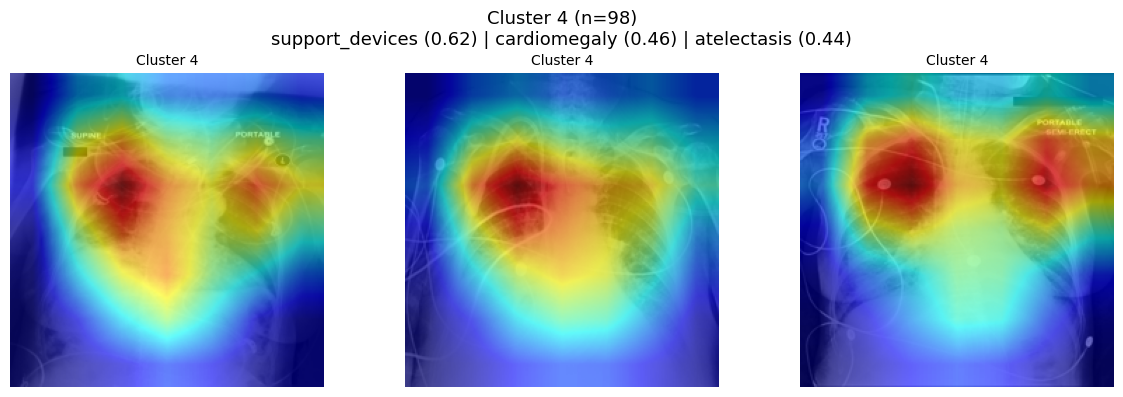

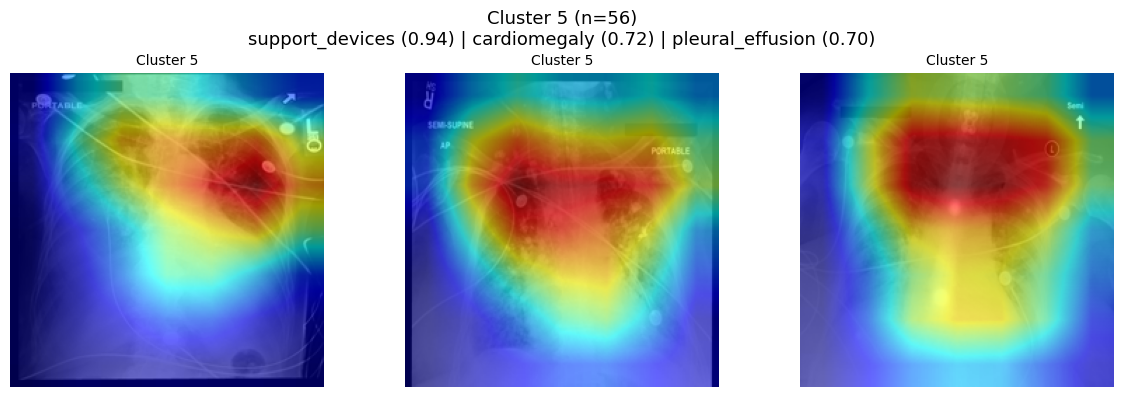

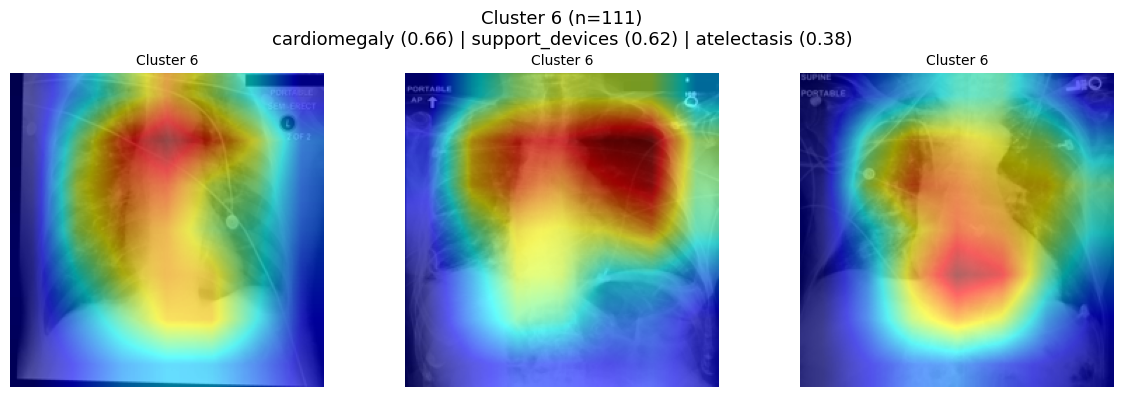

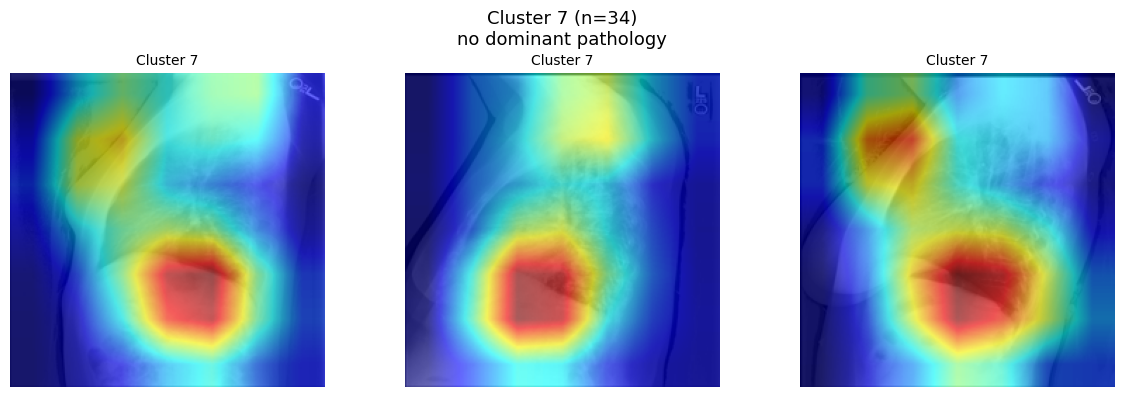

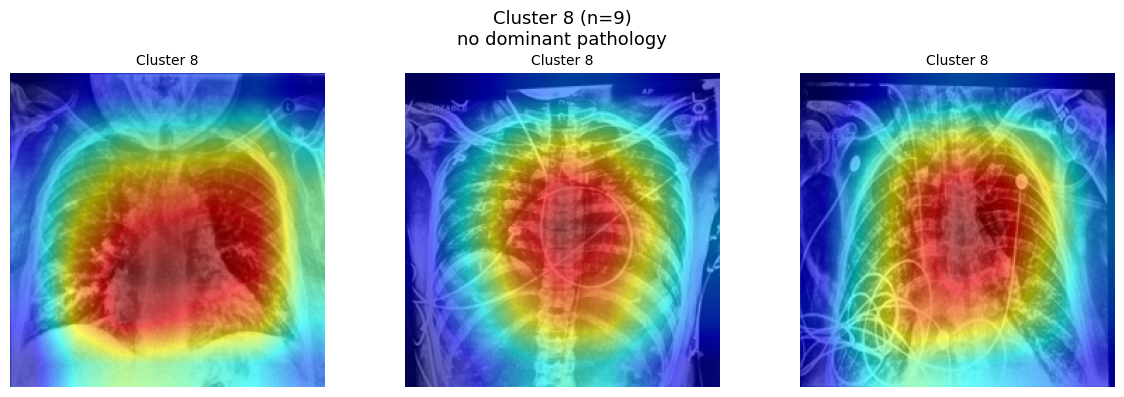

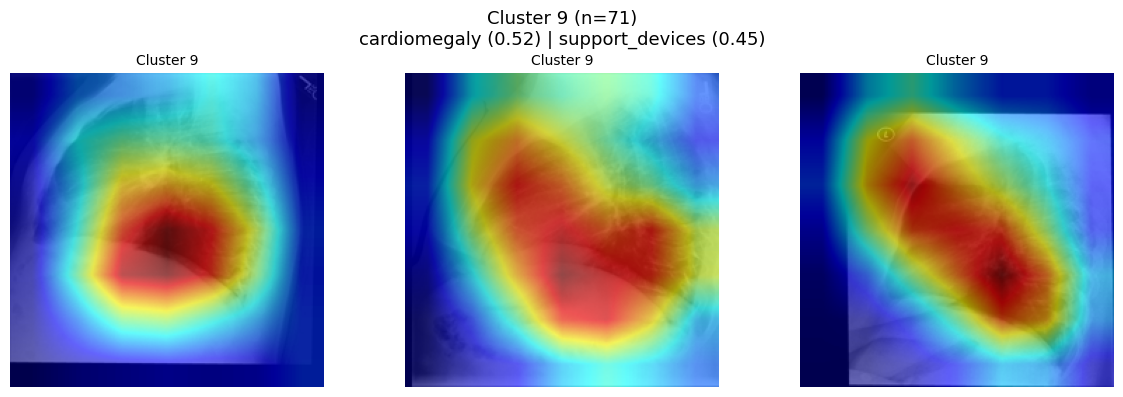

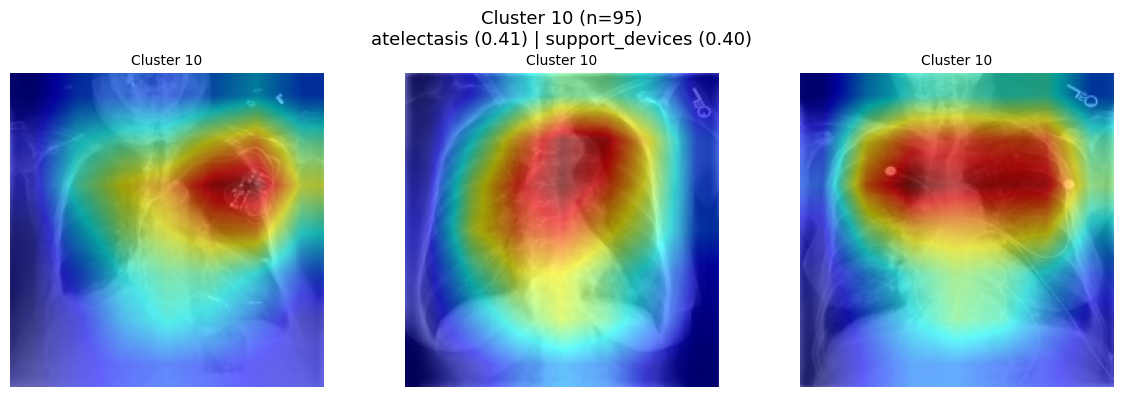

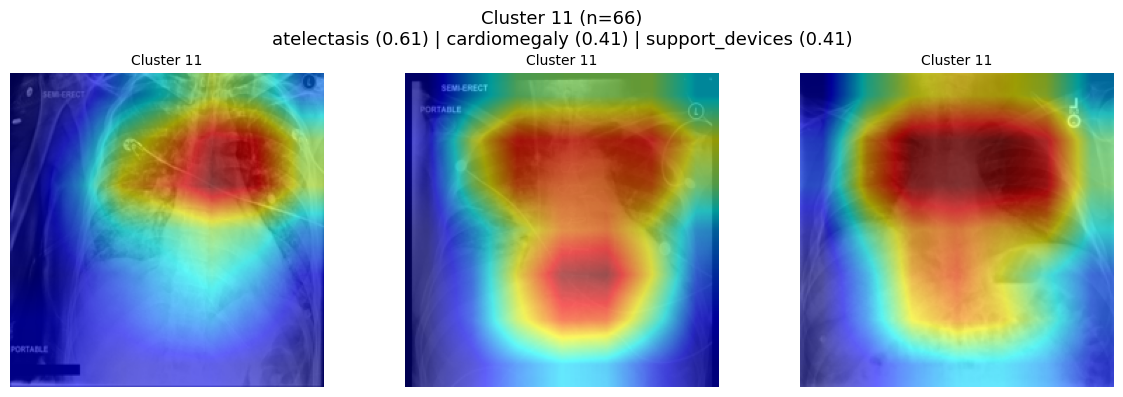

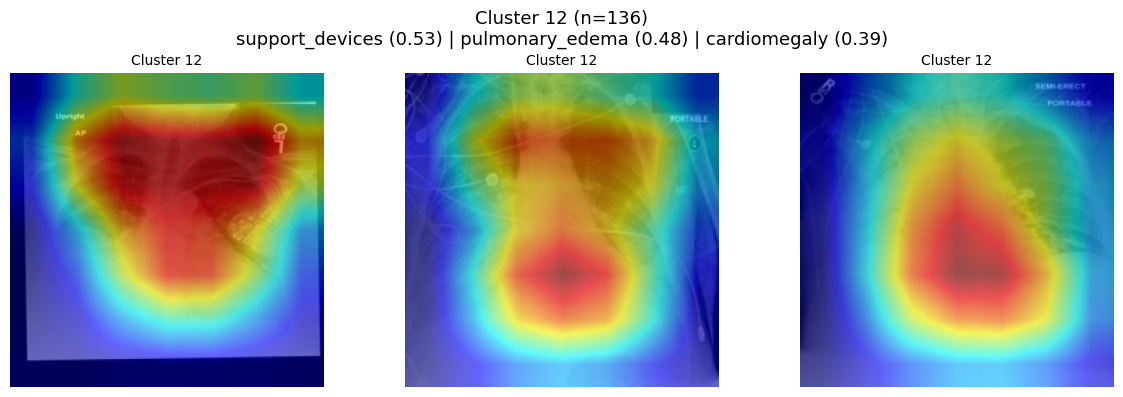

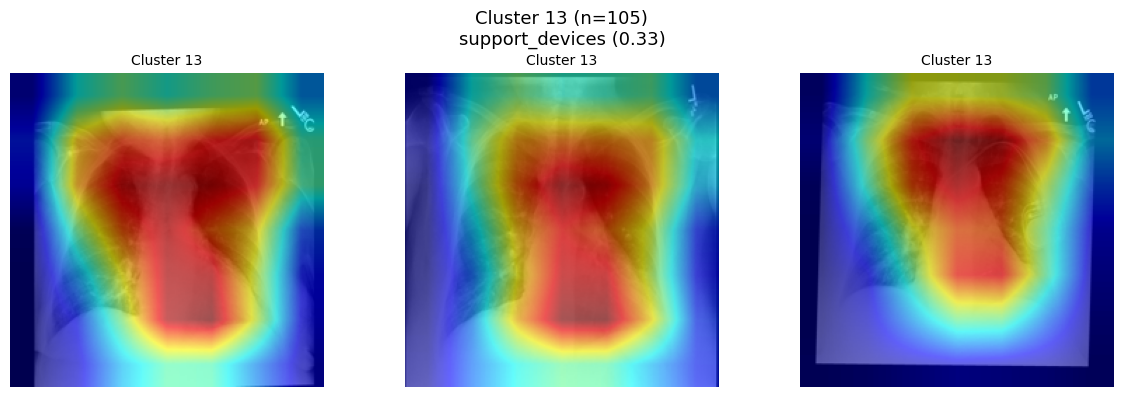

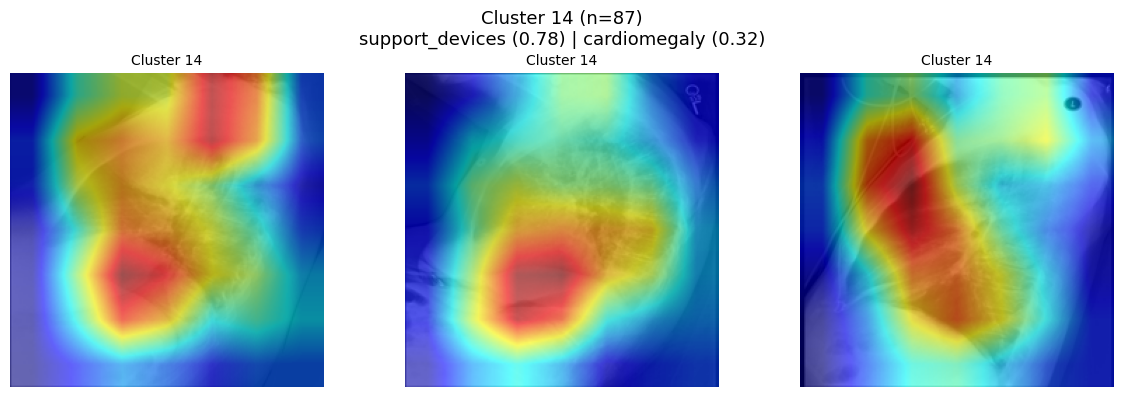

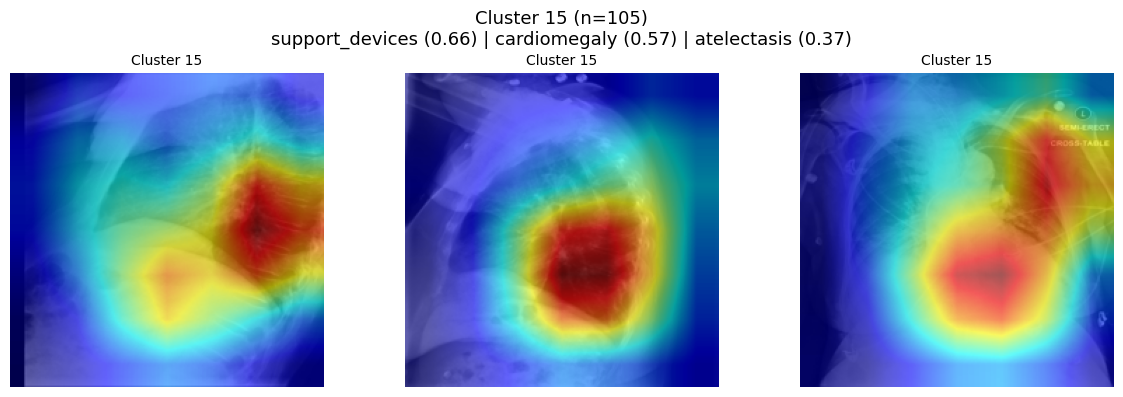

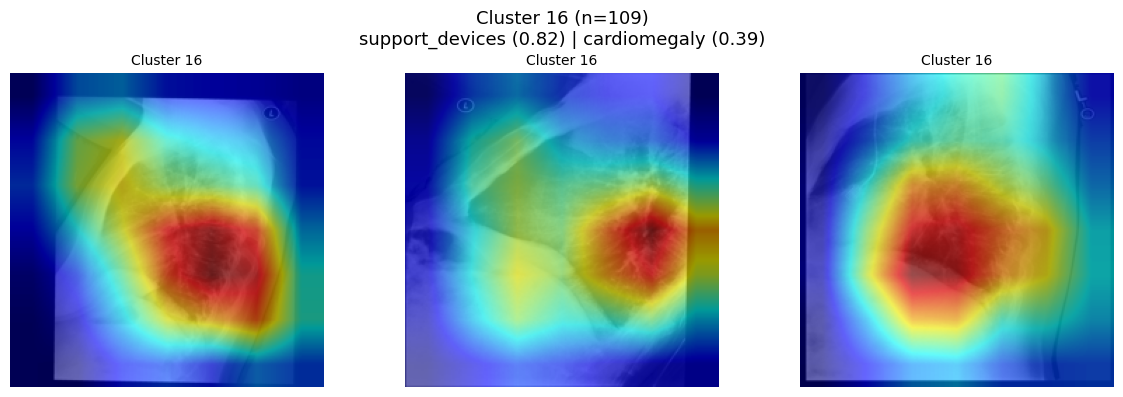

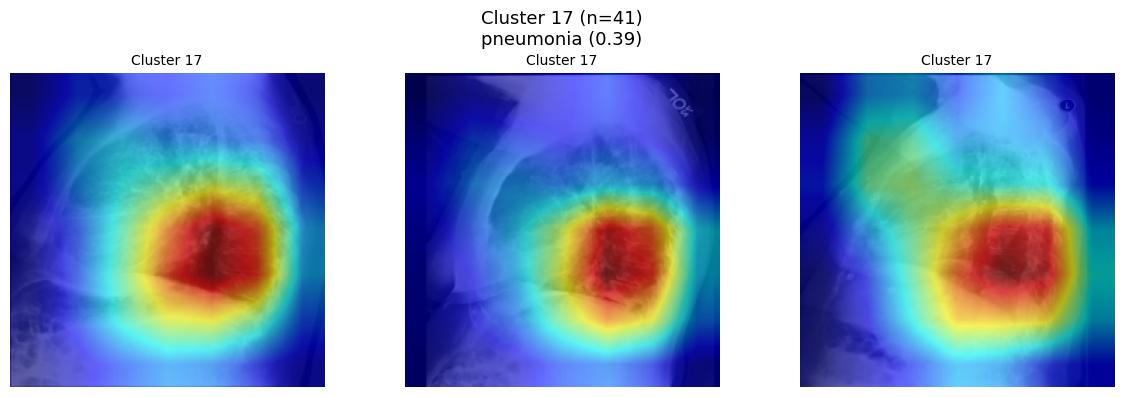

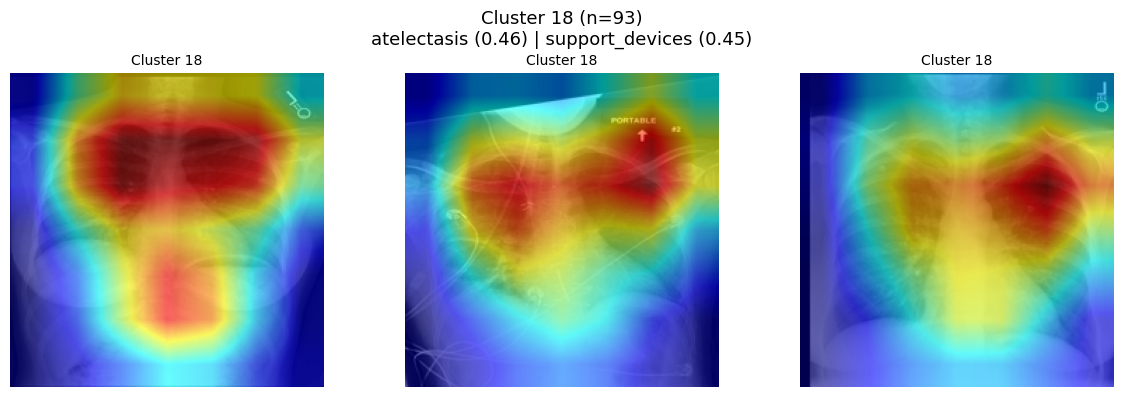

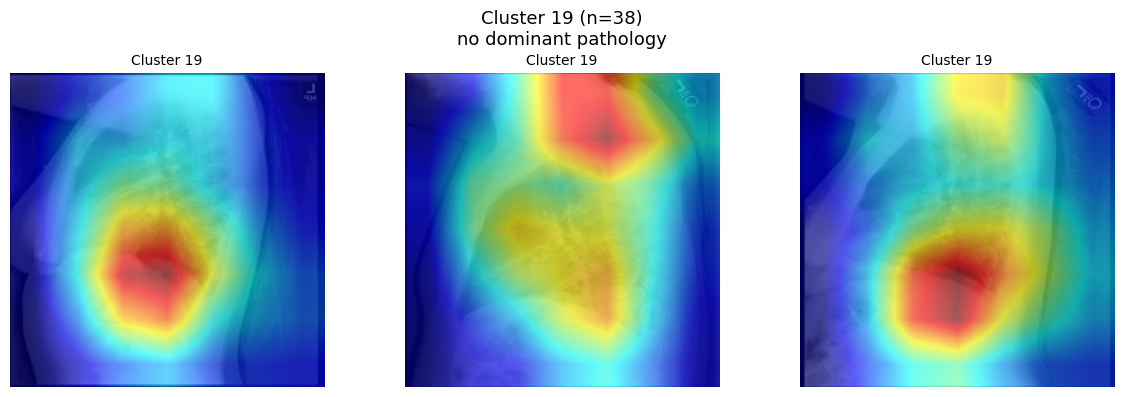

In [44]:
LABELS = [
    "pleural_effusion", "atelectasis", "pneumonia",
    "cardiomegaly", "pulmonary_edema", "pneumothorax",
    "support_devices"
]

plot_all_cluster_gradcams_with_labels(
    val_df_km,
    cam,
    CFG.IMAGE_ROOT,
    DEVICE,
    ratio_df,
    counts_df,
    LABELS,
    samples_per_cluster=3
)


In [9]:
import torchvision.transforms as T
from transformers import AutoTokenizer

img_tf = T.Compose([
    T.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE)),
    T.ToTensor(),
    T.Lambda(lambda x: x.repeat(3,1,1)),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

class MIMICImageTextDS(Dataset):
    def __init__(self, df, image_root):
        self.df = df.reset_index(drop=True)
        self.root = image_root

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rel = self.df.loc[idx, "rel_path"].strip().lstrip("/").replace("\\", "/")
        path = os.path.join(self.root.rstrip("/"), rel)
        img = Image.open(path).convert("L")
        img = img_tf(img)
        txt = self.df.loc[idx, "text"]
        return img, txt

from transformers import AutoTokenizer
import torch

def prompts_from_y(y_row, max_pos=1):
    pos = [LABELS[j] for j in range(len(LABELS)) if float(y_row[j]) > 0.5]
    if len(pos) == 0:
        pos = ["normal_no_finding"]
    pos = pos[:max_pos]
    return [f"chest x-ray: {LABEL_TEXT[l]}." for l in pos]

def make_collate(tokenizer, max_len=256, max_pos_prompts=1):
    def collate(batch):
        imgs, ys = zip(*batch)
        imgs = torch.stack(imgs, 0)   # [B,3,H,W]
        ys   = torch.stack(ys, 0)     # [B,L]

        prompt_texts = []
        prompt_owner = []
        for i in range(len(batch)):
            ps = prompts_from_y(ys[i], max_pos=max_pos_prompts)
            for p in ps:
                prompt_texts.append(p)
                prompt_owner.append(i)

        tok = tokenizer(
            prompt_texts,
            padding=True,
            truncation=True,
            max_length=max_len,
            return_tensors="pt"
        )

        B = imgs.size(0)
        M = len(prompt_texts)
        pos_mask = torch.zeros((B, M), dtype=torch.bool)
        for j, i in enumerate(prompt_owner):
            pos_mask[i, j] = True

        return imgs, tok, pos_mask, ys, prompt_texts
    return collate

tokenizer = AutoTokenizer.from_pretrained(CFG.TEXT_MODEL)

collate_fn = make_collate(tokenizer, max_len=CFG.MAX_LEN, max_pos_prompts=3)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Pszeudo-label (kuka)

In [8]:
LABELS = [
    "pleural_effusion",
    "atelectasis",
    "pneumonia",
    "cardiomegaly",
    "pulmonary_edema",
    "pneumothorax",
    "support_devices",
    "normal_no_finding",
]
label2idx = {l:i for i,l in enumerate(LABELS)}

LABEL_TEXT = {
    "pleural_effusion": "pleural effusion",
    "atelectasis": "atelectasis",
    "pneumonia": "pneumonia",
    "cardiomegaly": "cardiomegaly",
    "pulmonary_edema": "pulmonary edema",
    "pneumothorax": "pneumothorax",
    "support_devices": "support devices such as tubes or lines",
    "normal_no_finding": "no acute cardiopulmonary abnormality",
}


In [11]:
import numpy as np

def make_multilabel_targets(df, text_col="text", labels=LABELS):
    Y = np.zeros((len(df), len(labels)), dtype=np.float32)
    for i, t in enumerate(df[text_col].tolist()):
        for j, lab in enumerate(labels):
            st = classify_condition(t, DISEASE_PATTERNS[lab])
            Y[i, j] = 1.0 if st == "positive" else 0.0
    return Y


In [6]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torch

img_tf = T.Compose([
    T.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE)),
    T.ToTensor(),
    T.Lambda(lambda x: x.repeat(3,1,1)),
    T.Normalize(mean=[0.5,0.5,0.5], std=[0.25,0.25,0.25]),
])

class MIMICMultiLabelDS(Dataset):
    def __init__(self, df, image_root, targets):
        self.df = df.reset_index(drop=True)
        self.root = image_root
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rel = self.df.loc[idx, "rel_path"].strip().lstrip("/").replace("\\", "/")
        path = os.path.join(self.root.rstrip("/"), rel)
        img = Image.open(path).convert("L")
        img = img_tf(img)
        y = self.targets[idx]
        return img, y


In [13]:
import torch.nn as nn
import torchvision.models as models

class SimCLRBackbone(nn.Module):
    def __init__(self, simclr_path):
        super().__init__()
        backbone = models.resnet50(weights=None)
        backbone.fc = nn.Identity()
        state = torch.load(simclr_path, map_location="cpu")
        backbone.load_state_dict(state, strict=True)
        self.backbone = backbone
        self.feat_dim = 2048

    def forward(self, x):
        return self.backbone(x)  # [B,2048]

class MultiLabelModel(nn.Module):
    def __init__(self, simclr_path, num_labels):
        super().__init__()
        self.encoder = SimCLRBackbone(simclr_path)
        self.head = nn.Linear(self.encoder.feat_dim, num_labels)

    def forward(self, x):
        feats = self.encoder(x)
        logits = self.head(feats)
        return logits


In [14]:
SIMCLR_PATH = "/kaggle/input/resnet50-simclr-encoder/pytorch/default/1/resnet50_simclr_encoder.pth"
ml_model = MultiLabelModel(SIMCLR_PATH, num_labels=len(LABELS)).to(CFG.DEVICE)


In [15]:
def set_requires_grad(module, flag: bool):
    for p in module.parameters():
        p.requires_grad = flag

# warmup: encoder fagyasztva
set_requires_grad(ml_model.encoder, False)
set_requires_grad(ml_model.head, True)


In [21]:
import pandas as pd
train_df = pd.read_csv("/kaggle/input/train-dataset/train_filtered.csv")
val_df = pd.read_csv("/kaggle/input/validation-dataset/val_filtered.csv")
train_df["text"] = train_df["text"].apply(text_list_to_str)
val_df["text"]   = val_df["text"].apply(text_list_to_str)

Ytr = make_multilabel_targets(train_df, text_col="text", labels=LABELS)
Yva = make_multilabel_targets(val_df,   text_col="text", labels=LABELS)

train_loader = DataLoader(MIMICMultiLabelDS(train_df, CFG.IMAGE_ROOT, Ytr),
                          batch_size=CFG.BATCH_SIZE, shuffle=True,
                          num_workers=1, pin_memory=True)
val_loader = DataLoader(MIMICMultiLabelDS(val_df, CFG.IMAGE_ROOT, Yva),
                        batch_size=CFG.BATCH_SIZE, shuffle=False,
                        num_workers=1, pin_memory=True)


In [17]:
import torch
import torch.nn.functional as F

# pos_weight számítás train setből
Ytr = make_multilabel_targets(train_df, text_col="text", labels=LABELS)
pos = Ytr.sum(axis=0)
neg = len(Ytr) - pos
pos_weight = torch.tensor((neg / (pos + 1e-6)), dtype=torch.float32, device=CFG.DEVICE)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.AdamW([
    {"params": ml_model.head.parameters(), "lr": 2e-4},
], weight_decay=1e-4)

scaler = torch.amp.GradScaler('cuda', enabled=(CFG.DEVICE=="cuda"))


In [4]:
from tqdm.auto import tqdm

for epoch in range(CFG.EPOCHS):

    # 2. epochnál (epoch==1) finomhangolj layer4-et
    if epoch == 1:
        set_requires_grad(ml_model.encoder, False)
        set_requires_grad(ml_model.encoder.backbone.layer4, True)
        set_requires_grad(ml_model.head, True)
        optimizer = torch.optim.AdamW([
            {"params": ml_model.head.parameters(), "lr": 2e-4},
            {"params": ml_model.encoder.backbone.layer4.parameters(), "lr": 2e-5},
        ], weight_decay=1e-4)
        print("Unfreeze: layer4 + head")

    ml_model.train()
    running = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CFG.EPOCHS}")
    for imgs, y in pbar:
        imgs = imgs.to(CFG.DEVICE, non_blocking=True)
        y    = y.to(CFG.DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=(CFG.DEVICE=="cuda")):
            logits = ml_model(imgs)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running += loss.item()
        pbar.set_postfix(loss=running/(pbar.n+1))

    print(f"Epoch {epoch+1} train_loss={running/len(train_loader):.4f}")


NameError: name 'ml_model' is not defined

In [69]:
torch.save(ml_model.state_dict(), os.path.join(CFG.OUT_DIR, "multi_label_model.pth"))

In [24]:
from sklearn.metrics import roc_auc_score
import numpy as np

@torch.no_grad()
def eval_auc(model, loader):
    model.eval()
    all_logits, all_y = [], []
    for imgs, y in tqdm(loader, desc="Val", leave=False):
        imgs = imgs.to(CFG.DEVICE)
        logits = model(imgs).cpu().numpy()
        all_logits.append(logits)
        all_y.append(y.numpy())
    logits = np.concatenate(all_logits, 0)
    ytrue  = np.concatenate(all_y, 0)

    probs = 1/(1+np.exp(-logits))
    aucs = {}
    for j, lab in enumerate(LABELS):
        # ha egy labelben nincs pozitív a valban, roc_auc hibázik -> try
        try:
            aucs[lab] = roc_auc_score(ytrue[:, j], probs[:, j])
        except Exception:
            aucs[lab] = None
    return aucs

aucs = eval_auc(ml_model, val_loader)
print(aucs)


Val:   0%|          | 0/29 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x789198178180>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x789198178180>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

{'pleural_effusion': 0.7386159600997506, 'atelectasis': 0.7320866015172945, 'pneumonia': 0.6803598556335063, 'cardiomegaly': 0.6940782174645408, 'pulmonary_edema': 0.7536766007396987, 'pneumothorax': 0.5368518518518518, 'support_devices': 0.6946635943401545, 'normal_no_finding': 0.5856337316950009}


## Visual Language Model


In [3]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image

class MIMICImageY(Dataset):
    def __init__(self, df, image_root, Y, transform=None):
        self.df = df.reset_index(drop=True)
        self.root = image_root
        self.transform = transform if transform is not None else img_tf

        # targets
        if isinstance(Y, torch.Tensor):
            self.Y = Y.float()
        else:
            self.Y = torch.tensor(Y, dtype=torch.float32)

        assert len(self.df) == len(self.Y), f"df len {len(self.df)} != Y len {len(self.Y)}"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rel = self.df.loc[idx, "rel_path"]
        if not isinstance(rel, str):
            rel = str(rel)

        rel = rel.strip().lstrip("/").replace("\\", "/")
        path = os.path.join(self.root.rstrip("/"), rel)

        img = Image.open(path).convert("L")
        img = self.transform(img)

        y = self.Y[idx]
        return img, y


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from transformers import AutoModel

class ProjectionHead(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.GELU(),
            nn.Linear(in_dim, out_dim)
        )

    def forward(self, x):
        x = self.net(x)
        return F.normalize(x, dim=-1)

class ImageEncoder(nn.Module):
    def __init__(self, simclr_encoder_path=None):
        super().__init__()
        backbone = models.resnet50(weights=None)
        feat_dim = backbone.fc.in_features
        backbone.fc = nn.Identity()

        if simclr_encoder_path is not None:
            sd = torch.load(simclr_encoder_path, map_location="cpu")
            # Ez akkor OK, ha te: torch.save(model.encoder.state_dict(), path)
            backbone.load_state_dict(sd, strict=True)

        self.backbone = backbone
        self.feat_dim = feat_dim

    def forward(self, x):
        return self.backbone(x)  # [B, 2048]

class VLM_PseudoCLIP(nn.Module):
    """
    CLIP-szerű VLM:
      - image encoder: ResNet50 (SimCLR encoderrel init-elhető)
      - text encoder: HF AutoModel (pl. DistilBERT)
      - projection: L2 normált embeddingek
      - logit_scale: tanulható skála (CLIP temperature inverse)
      - opcionális multitask BCE: image-features -> multilabel logits
    """
    def __init__(self, text_model_name, embed_dim=256, temp_init=0.07,
                 simclr_encoder_path=None, multitask_bce=False, num_labels=8):
        super().__init__()

        self.img_enc = ImageEncoder(simclr_encoder_path=simclr_encoder_path)
        self.txt_enc = AutoModel.from_pretrained(text_model_name)

        self.img_proj = ProjectionHead(self.img_enc.feat_dim, embed_dim)
        self.txt_proj = ProjectionHead(self.txt_enc.config.hidden_size, embed_dim)

        # tanulható logit scale (CLIP)
        self.logit_scale = nn.Parameter(
            torch.tensor(np.log(1.0 / temp_init), dtype=torch.float32)
        )

        self.multitask_bce = multitask_bce
        if multitask_bce:
            self.cls_head = nn.Linear(self.img_enc.feat_dim, num_labels)

    def encode_image(self, imgs):
        h = self.img_enc(imgs)     # [B,2048]
        z = self.img_proj(h)       # [B,D]
        return h, z

    def encode_text(self, tok):
        # csak tensor kulcsok menjenek a modelbe (input_ids, attention_mask, ...)
        bert_tok = {k: v for k, v in tok.items() if torch.is_tensor(v)}
        out = self.txt_enc(**bert_tok)
        x = out.last_hidden_state                        # [M,T,H]
        attn = bert_tok["attention_mask"].unsqueeze(-1)  # [M,T,1]
        x = (x * attn).sum(dim=1) / attn.sum(dim=1).clamp(min=1e-6)  # mean pool
        z = self.txt_proj(x)                             # [M,D]
        return z

    def forward(self, imgs, tok):
        _, zi = self.encode_image(imgs)   # [B,D]
        zt = self.encode_text(tok)        # [M,D]
        scale = self.logit_scale.exp().clamp(1, 100)
        logits = scale * (zi @ zt.t())    # [B,M]
        return logits


In [5]:
def clip_loss_multipos(logits, pos_mask):
    """
    logits: [B,M]
    pos_mask: [B,M] bool, True ahol prompt pozitív az adott képhez
    """
    # i->t
    logp_i2t = logits - torch.logsumexp(logits, dim=1, keepdim=True)
    has_pos = pos_mask.any(dim=1)
    pos_logsum = torch.logsumexp(logp_i2t.masked_fill(~pos_mask, -1e9), dim=1)
    loss_i2t = -(pos_logsum[has_pos]).mean()

    # t->i
    logits_t = logits.t()           # [M,B]
    pos_mask_t = pos_mask.t()       # [M,B]
    logp_t2i = logits_t - torch.logsumexp(logits_t, dim=1, keepdim=True)
    has_pos_t = pos_mask_t.any(dim=1)
    pos_logsum_t = torch.logsumexp(logp_t2i.masked_fill(~pos_mask_t, -1e9), dim=1)
    loss_t2i = -(pos_logsum_t[has_pos_t]).mean()

    return 0.5 * (loss_i2t + loss_t2i)


In [14]:
import os, numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

DEVICE = CFG.DEVICE
FP16 = CFG.FP16

import pandas as pd

train_df = pd.read_csv("/kaggle/input/train-dataset/train_filtered.csv")
val_df   = pd.read_csv("/kaggle/input/validation-dataset/val_filtered.csv")

train_df["text"] = train_df["text"].apply(text_list_to_str)
val_df["text"]   = val_df["text"].apply(text_list_to_str)

Ytr = make_multilabel_targets(train_df, text_col="text", labels=LABELS)
Yva = make_multilabel_targets(val_df,   text_col="text", labels=LABELS)

pos = Ytr.sum(axis=0)
neg = len(Ytr) - pos
pos_weight = torch.tensor((neg / (pos + 1e-6)), dtype=torch.float32, device=DEVICE)
bce_crit = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

train_loader = DataLoader(
    MIMICImageY(train_df, CFG.IMAGE_ROOT, Ytr),
    batch_size=CFG.BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    MIMICImageY(val_df, CFG.IMAGE_ROOT, Yva),
    batch_size=CFG.BATCH_SIZE,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=collate_fn,
)

SIMCLR_ENCODER = "/kaggle/input/resnet50-simclr-encoder/pytorch/default/1/resnet50_simclr_encoder.pth"

multitask_bce = True  # ajánlott (stabilabb)
model = VLM_PseudoCLIP(
    text_model_name=CFG.TEXT_MODEL,
    embed_dim=256,
    temp_init=0.07,
    simclr_encoder_path=SIMCLR_ENCODER,
    multitask_bce=multitask_bce,
    num_labels=len(LABELS),
).to(DEVICE)

import torch.nn as nn

def set_requires_grad(x, flag: bool):
    if isinstance(x, nn.Parameter):
        x.requires_grad = flag
        return
    for p in x.parameters():
        p.requires_grad = flag

def make_optimizer_warmup(model):
    # csak proj + logit_scale (+ cls_head)
    set_requires_grad(model.img_enc, False)
    set_requires_grad(model.txt_enc, False)
    set_requires_grad(model.img_proj, True)
    set_requires_grad(model.txt_proj, True)
    model.logit_scale.requires_grad_(True)
    if multitask_bce:
        set_requires_grad(model.cls_head, True)

    params = [
        {"params": model.img_proj.parameters(), "lr": 2e-4},
        {"params": model.txt_proj.parameters(), "lr": 2e-4},
        {"params": [model.logit_scale],         "lr": 2e-4},
    ]
    if multitask_bce:
        params += [{"params": model.cls_head.parameters(), "lr": 2e-4}]

    return torch.optim.AdamW(params, weight_decay=1e-4)

def make_optimizer_unfreeze(model):
    set_requires_grad(model.img_enc, False)
    set_requires_grad(model.img_enc.backbone.layer4, True)

    set_requires_grad(model.txt_enc, False)
    try:
        set_requires_grad(model.txt_enc.transformer.layer[-2:], True)
    except Exception:
        set_requires_grad(model.txt_enc, True)

    set_requires_grad(model.img_proj, True)
    set_requires_grad(model.txt_proj, True)
    model.logit_scale.requires_grad_(True)
    if multitask_bce:
        set_requires_grad(model.cls_head, True)

    params = [
        {"params": model.img_proj.parameters(), "lr": 2e-4},
        {"params": model.txt_proj.parameters(), "lr": 2e-4},
        {"params": [model.logit_scale],         "lr": 2e-4},
        {"params": model.img_enc.backbone.layer4.parameters(), "lr": 2e-5},
    ]
    params += [{"params": model.txt_enc.parameters(), "lr": 2e-5}]
    if multitask_bce:
        params += [{"params": model.cls_head.parameters(), "lr": 2e-4}]

    return torch.optim.AdamW(params, weight_decay=1e-4)

scaler = torch.amp.GradScaler('cuda', enabled=(DEVICE=="cuda" and FP16))
LAMBDA_BCE = 1.0

def train_one_epoch(loader, optimizer):
    model.train()
    running = 0.0
    for imgs, tok, pos_mask, ys, _prompt_texts in tqdm(loader, desc="train", leave=False):
        imgs = imgs.to(DEVICE, non_blocking=True)
        ys = ys.to(DEVICE, non_blocking=True)
        pos_mask = pos_mask.to(DEVICE, non_blocking=True)
        tok = {k:(v.to(DEVICE, non_blocking=True) if torch.is_tensor(v) else v) for k,v in tok.items()}

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=(DEVICE=="cuda" and FP16)):
            logits = model(imgs, tok)  # [B,M]
            loss_clip = clip_loss_multipos(logits, pos_mask)

            if multitask_bce:
                h, _ = model.encode_image(imgs)     # [B,2048]
                logits_y = model.cls_head(h)        # [B,L]
                loss_bce = bce_crit(logits_y, ys)
                loss = loss_clip + LAMBDA_BCE * loss_bce
            else:
                loss = loss_clip

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running += float(loss.item())

    return running / max(1, len(loader))

@torch.no_grad()
def eval_clip_loss(loader, max_batches=50):
    model.eval()
    losses = []
    for bi, (imgs, tok, pos_mask, ys, _prompt_texts) in enumerate(tqdm(loader, desc="val", leave=False)):
        if max_batches is not None and bi >= max_batches:
            break
        imgs = imgs.to(DEVICE, non_blocking=True)
        pos_mask = pos_mask.to(DEVICE, non_blocking=True)
        tok = {k:(v.to(DEVICE, non_blocking=True) if torch.is_tensor(v) else v) for k,v in tok.items()}

        with torch.amp.autocast('cuda', enabled=(DEVICE=="cuda" and FP16)):
            logits = model(imgs, tok)
            loss = clip_loss_multipos(logits, pos_mask)
        losses.append(float(loss.item()))
    return float(np.mean(losses)) if losses else None

optimizer = make_optimizer_warmup(model)

for epoch in range(5):
    if epoch == 2:
        optimizer = make_optimizer_unfreeze(model)
        print(">>> Unfreeze: img layer4 + (txt last layers)")

    model.train()
    running = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/5")
    for imgs, tok, pos_mask, ys, _prompt_texts in pbar:
        imgs = imgs.to(DEVICE, non_blocking=True)
        ys = ys.to(DEVICE, non_blocking=True)
        pos_mask = pos_mask.to(DEVICE, non_blocking=True)
        tok = {k:(v.to(DEVICE, non_blocking=True) if torch.is_tensor(v) else v) for k,v in tok.items()}

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=(DEVICE=="cuda" and FP16)):
            logits = model(imgs, tok)
            loss_clip = clip_loss_multipos(logits, pos_mask)

            if multitask_bce:
                h, _ = model.encode_image(imgs)
                logits_y = model.cls_head(h)
                loss_bce = bce_crit(logits_y, ys)
                loss = loss_clip + LAMBDA_BCE * loss_bce
            else:
                loss = loss_clip

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running += float(loss.item())
        pbar.set_postfix(loss=running/(pbar.n+1),
                         scale=float(model.logit_scale.exp().clamp(1,100).item()))

    print(f"Epoch {epoch+1}/5 train_loss={running/len(train_loader):.4f}")

# mentés
torch.save(model.state_dict(), os.path.join(CFG.OUT_DIR, "vlm_pseudo_prompt_5ep.pth"))
print("Saved:", os.path.join(CFG.OUT_DIR, "vlm_pseudo_prompt_5ep.pth"))



/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1/5:   0%|          | 0/3499 [00:00<?, ?it/s]

Epoch 1/5 train_loss=5.1141


Epoch 2/5:   0%|          | 0/3499 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9d4076c400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 2/5 train_loss=5.0866
>>> Unfreeze: img layer4 + (txt last layers)


Epoch 3/5:   0%|          | 0/3499 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9d4076c400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9d4076c400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 3/5 train_loss=5.0375


Epoch 4/5:   0%|          | 0/3499 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9d4076c400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9d4076c400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 4/5 train_loss=4.9962


Epoch 5/5:   0%|          | 0/3499 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9d4076c400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9d4076c400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 5/5 train_loss=4.9716
Saved: /kaggle/working/mimic_vit_out/vlm_pseudo_prompt_5ep.pth


In [17]:
import torch

batch = next(iter(train_loader))
imgs, tok, pos_mask, ys, prompt_texts = batch

print("imgs:", imgs.shape)          # [B,3,224,224]
print("pos_mask:", pos_mask.shape)  # [B,M]
print("ys:", ys.shape)              # [B,L]
print("M prompts:", len(prompt_texts))

# van-e legalább 1 pozitív prompt minden képre?
pos_per_img = pos_mask.sum(dim=1)
print("pos_per_img min/mean/max:", int(pos_per_img.min()), float(pos_per_img.float().mean()), int(pos_per_img.max()))

# mennyi pozitív label van képenként?
pos_y = (ys > 0.5).sum(dim=1)
print("pos_labels min/mean/max:", int(pos_y.min()), float(pos_y.float().mean()), int(pos_y.max()))


imgs: torch.Size([64, 3, 224, 224])
pos_mask: torch.Size([64, 105])
ys: torch.Size([64, 8])
M prompts: 105
pos_per_img min/mean/max: 1 1.640625 3
pos_labels min/mean/max: 0 1.34375 5


## VLM kiértékelés

In [15]:
PROMPT_BANK = [f"chest x-ray: {LABEL_TEXT[l]}." for l in LABELS]

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(CFG.TEXT_MODEL)

tok_bank = tokenizer(
    PROMPT_BANK,
    padding=True,
    truncation=True,
    max_length=CFG.MAX_LEN,
    return_tensors="pt"
)
tok_bank = {k:v.to(DEVICE) for k,v in tok_bank.items() if torch.is_tensor(v)}


In [16]:
@torch.no_grad()
def compute_embeddings_images(model, loader):
    model.eval()
    all_img, all_y = [], []
    for imgs, tok, pos_mask, ys, _ in tqdm(loader, desc="Image emb"):
        imgs = imgs.to(DEVICE)
        h, zi = model.encode_image(imgs)
        all_img.append(zi.cpu())
        all_y.append(ys.cpu())
    return torch.cat(all_img, 0), torch.cat(all_y, 0)

@torch.no_grad()
def compute_embeddings_text(model, tok_bank):
    model.eval()
    zt = model.encode_text(tok_bank)
    return zt.cpu()

zi, Ytrue = compute_embeddings_images(model, val_loader)
zt = compute_embeddings_text(model, tok_bank)

print("zi:", zi.shape, "zt:", zt.shape)  # [N,D], [L,D]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Image emb:   0%|          | 0/29 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9d4076c400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child processhuggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

Exception ignored in:

zi: torch.Size([1854, 256]) zt: torch.Size([8, 256])


In [17]:
import torch
import numpy as np

def eval_label_recall_random(Y, ks=(1,3,5), trials=200):
    # Y: [N,L] 0/1 tensor
    Y = Y.bool()
    N, L = Y.shape
    out = {f"R@{k}": [] for k in ks}

    for _ in range(trials):
        ranks = torch.stack([torch.randperm(L) for _ in range(N)], 0)  # [N,L]
        for k in ks:
            hit = 0
            for i in range(N):
                pos = torch.where(Y[i])[0].tolist()
                if len(pos) == 0:
                    continue
                topk = ranks[i, :k].tolist()
                if any(p in topk for p in pos):
                    hit += 1
            out[f"R@{k}"].append(hit / N)

    return {k: float(np.mean(v)) for k,v in out.items()}, {k: float(np.std(v)) for k,v in out.items()}

Y = torch.tensor(Yva, dtype=torch.float32) 
mean_rand = eval_label_recall_random(Y, ks=(1,3,5), trials=200)
print("Random baseline:", mean_rand)


Random baseline: ({'R@1': 0.14867044228694712, 'R@3': 0.355302049622438, 'R@5': 0.48624056094929885}, {'R@1': 0.007271593631962296, 'R@3': 0.008241263751118699, 'R@5': 0.0062025678862895044})


In [18]:
import torch
import torch.nn.functional as F
import numpy as np

class VLMGradCAM:
    def __init__(self, vlm_model, target_layer):
        self.model = vlm_model
        self.layer = target_layer
        self.acts = None
        self.grads = None

        self.layer.register_forward_hook(self._fwd)
        self.layer.register_full_backward_hook(self._bwd)

    def _fwd(self, module, inp, out):
        self.acts = out  # [B,C,H,W]

    def _bwd(self, module, grad_in, grad_out):
        self.grads = grad_out[0]  # [B,C,H,W]

    def __call__(self, imgs, tok, prompt_index: int):
        """
        imgs: [B,3,224,224] (B=1 ajánlott)
        tok: tokenizált prompt batch, shape [M,...]
        prompt_index: melyik prompt oszlopára cam-et kérsz (0..M-1)
        """
        self.model.zero_grad(set_to_none=True)

        logits = self.model(imgs, tok)   # [B,M]
        score = logits[:, prompt_index].sum()
        score.backward()

        acts = self.acts
        grads = self.grads
        w = grads.mean(dim=(2,3), keepdim=True)      # [B,C,1,1]
        cam = (w * acts).sum(dim=1)                  # [B,H,W]
        cam = F.relu(cam)

        cam = cam - cam.amin(dim=(1,2), keepdim=True)
        cam = cam / (cam.amax(dim=(1,2), keepdim=True) + 1e-8)
        return cam.detach().cpu().numpy()


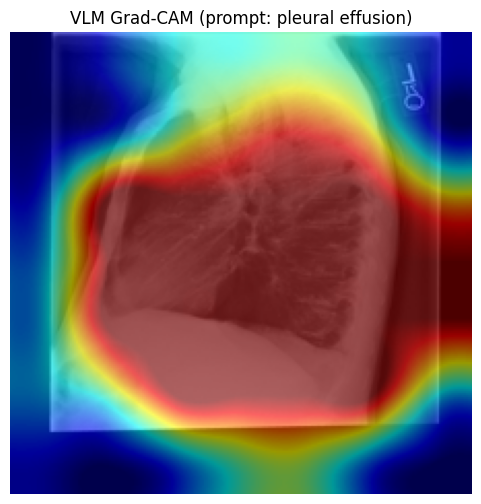

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from transformers import AutoTokenizer

img_path = "/kaggle/input/mimic-cxr-dataset/official_data_iccv_final/files/p10/p10000032/s50414267/174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962.jpg"  # <- ide a saját
img_pil = Image.open(img_path).convert("L")
img = img_tf(img_pil).unsqueeze(0).to(CFG.DEVICE)  # [1,3,224,224]

# 2) prompt(ok)
prompt_texts = ["chest x-ray: cardiomegaly."]  # vagy amit akarsz
tokenizer = AutoTokenizer.from_pretrained(CFG.TEXT_MODEL)
tok = tokenizer(prompt_texts, padding=True, truncation=True, max_length=CFG.MAX_LEN, return_tensors="pt")
tok = {k:v.to(DEVICE) for k,v in tok.items()}

# 3) Grad-CAM
cam_engine = VLMGradCAM(model, model.img_enc.backbone.layer4)  # layer4 output
cam_map = cam_engine(img, tok, prompt_index=0)[0]              # [H,W]

# 4) overlay megjelenítés
img_np = np.array(img_pil.resize((224,224)))
cam_small = cam_map
cam_big = cv2.resize(cam_small, (224, 224), interpolation=cv2.INTER_CUBIC)  # (224,224)
cam_big = np.clip(cam_big, 0, 1)
heat = cv2.applyColorMap(np.uint8(255*cam_big), cv2.COLORMAP_JET)
overlay = 0.6*heat + 0.4*cv2.cvtColor(img_np, cv2.COLOR_GRAY2BGR)
overlay = overlay.astype(np.uint8)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis("off")
plt.title("VLM Grad-CAM (prompt: pleural effusion)")
plt.show()
